In [1]:
import os
import urllib.request
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from typing import List, Dict, Any, Tuple, Optional
from textwrap import dedent
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.retrievers import BaseRetriever
import json

print("✅ 라이브러리 import 완료!")


✅ 라이브러리 import 완료!


In [2]:
import re
from langchain_core.documents import Document  # ✅ 수정

# ✅ 1. txt 파일 불러오기
with open(r"C:\Users\helen\Desktop\kt cloud tech up\basic_project\HTP_DATA\브런치_집-나무-사람 해석 수기본.txt", "r", encoding="utf-8") as f:  # ✅ 경로 수정
    text = f.read()

print("텍스트 로드 완료! 총 길이:", len(text))

# ✅ 2. 카테고리 자동 감지 함수
def detect_category(text):
    if "집" in text:
        return "집"
    elif "나무" in text:
        return "나무"
    elif "사람" in text:
        return "사람"
    else:
        return "기타"

# 1. 줄바꿈 제거, 공백 정리
text = re.sub(r'\s+', ' ', text).strip()  # 연속 공백 모두 1칸으로 통일

# 2. 번호 기준으로 청크 나누기
chunks = re.split(r'(?=\n?\d+\.)', text)
chunks = [chunk.strip() for chunk in chunks if chunk.strip()]

# ✅ 4. 각 청크에 카테고리 태깅 + '*' 기준 2차 청킹
langchain_docs = []
for i, chunk in enumerate(chunks):
    # '*', '■' 기호가 있으면 추가로 분리
    if '■' in chunk or '*' in chunk:
        subchunks = re.split(r'(?=[■*])', chunk)
        subchunks = [s.strip() for s in subchunks if s.strip()]
        for j, subchunk in enumerate(subchunks):
            category = detect_category(subchunk)
            langchain_docs.append(
                Document(
                    page_content=subchunk,
                    metadata={
                        "chunk_index": f"{i + 1}-{j + 1}",  # ex: 3-1, 3-2
                        "category": category
                    }
                )
            )
    else:
        category = detect_category(chunk)
        langchain_docs.append(
            Document(
                page_content=chunk,
                metadata={
                    "chunk_index": i + 1,
                    "category": category
                }
            )
        )

# ✅ 5. 결과 확인
print(f"총 {len(langchain_docs)}개 청크 생성 완료\n")
for doc in langchain_docs[:5]:  # 상위 5개만 미리보기
    print(f"[{doc.metadata['category']}] {doc.page_content}")
    print("-" * 60)

텍스트 로드 완료! 총 길이: 52954
총 194개 청크 생성 완료

[기타] ﻿
------------------------------------------------------------
[집] 1. 제목: HTP : 집 집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다. 자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다. 지붕 지붕의 핵심은 머리로 상상할 수 있는 생각을 나타낸다.
------------------------------------------------------------
[기타] ■ 과도하게 큰 지붕을 그린다 자신만의 환상을 가지고 있다 사회생활을 피하며 자신만의 상상에 몰두한다 지붕이 그림의 전부인 것 마냥 그린다 상상과 공상을 통해 일상생활을 유지한다 학대를 받았을 가능성이 존재한다. 단 이것이 학대를 나타내는 지표로 사용되어서는 안 된다. 현실적으로 통용되지 않는 정신적인 망상을 할 수 있다 망상을 통해 일상생활을 도피하려는 시도일 수 있다
------------------------------------------------------------
[기타] ■ 지붕이 없다 지능 발달이 뒤쳐져 있을 수 있다. 단 이것이 지능 발달의 수준을 판가름 하는 진단기준이 되어서는 안 된다. 자신을 표현하는 방법을 완전히 잃어 버린 경우가 존재한다 단순한 직선, 또는 1차원 적으로 간단히 지붕을 표현한다 매우 경직되어 있다 남에게 잘 어울리지 못 한다
------------------------------------------------------------
[기타] ■ 여러 번 덧칠하거나 진하게 칠함으로써 지붕을 강조한다 환상적인 상상을 통해 현실을 도피하려는 시도이다 정신적으로 어려워지기 시작하는 경우 빈번히 나타나는 징조 중 하나이다. 단 이것이 정신적인 어려움을 나타내는 지표로 사용되어서는 안 된다. 지붕의 꼭대기가 열려 있다 현실과 자신의 생각을 구별하기 어려워 

In [3]:
# 카테고리가 잘 들어갔는지 확인
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i}: {doc.metadata.get('category', '없음')}")

1: 기타
2: 집
3: 기타
4: 기타
5: 기타
6: 사람
7: 사람
8: 사람
9: 사람
10: 기타
11: 집
12: 기타
13: 사람
14: 기타
15: 집
16: 집
17: 집
18: 집
19: 기타
20: 집
21: 기타
22: 사람
23: 기타
24: 기타
25: 사람
26: 기타
27: 기타
28: 집
29: 기타
30: 집
31: 기타
32: 기타
33: 기타
34: 집
35: 집
36: 집
37: 집
38: 집
39: 집
40: 집
41: 기타
42: 집
43: 집
44: 집
45: 집
46: 집
47: 기타
48: 사람
49: 집
50: 집
51: 나무
52: 나무
53: 나무
54: 나무
55: 나무
56: 나무
57: 나무
58: 나무
59: 나무
60: 나무
61: 나무
62: 나무
63: 나무
64: 나무
65: 나무
66: 사람
67: 집
68: 기타
69: 집
70: 기타
71: 나무
72: 나무
73: 집
74: 기타
75: 기타
76: 사람
77: 기타
78: 사람
79: 기타
80: 기타
81: 기타
82: 기타
83: 사람
84: 기타
85: 기타
86: 기타
87: 집
88: 사람
89: 사람
90: 기타
91: 기타
92: 사람
93: 나무
94: 기타
95: 사람
96: 사람
97: 사람
98: 기타
99: 나무
100: 나무
101: 나무
102: 사람
103: 사람
104: 집
105: 사람
106: 사람
107: 기타
108: 사람
109: 기타
110: 기타
111: 기타
112: 사람
113: 집
114: 기타
115: 사람
116: 기타
117: 사람
118: 기타
119: 사람
120: 사람
121: 사람
122: 집
123: 기타
124: 기타
125: 기타
126: 기타
127: 기타
128: 사람
129: 사람
130: 기타
131: 집
132: 집
133: 기타
134: 기타
135: 기타
136: 집
137: 집
138: 기타
139: 사람
140: 집
141: 사람
142: 집
143: 기타


In [4]:
langchain_docs[101]

Document(metadata={'chunk_index': '17-1', 'category': '사람'}, page_content='3. 제목: HTP : 사람 사람 그림은 매우 직관적으로 자신의 삶을 드러낸다. 즉, 사람을 그린 그림은 엄청난 정보를 줄 수 있지만 그것을 해석하는 것에 있어서 어려움을 겪게 된다. 그 이유는 주는 정보가 방대하여 해석을 하기에 어려운 부분이 존재하기도 하나, 다양한 표현과 의미가 나타내는 포괄정인 정확한 의도를 깨닫기 난해하기 때문이다.')

In [5]:
# 카테고리 수정
for i, doc in enumerate(langchain_docs, start=1):
    if 0 <= i <= 51:
        doc.metadata['category'] = '집'
    elif 52 <= i <= 101:
        doc.metadata['category'] = '나무'
    elif 102 <= i :
        doc.metadata['category'] = '사람'


In [6]:
# 수정된 카테고리
for i, doc in enumerate(langchain_docs, start=1):
    print(f"{i-1}: {doc.metadata.get('category', '없음')}")

0: 집
1: 집
2: 집
3: 집
4: 집
5: 집
6: 집
7: 집
8: 집
9: 집
10: 집
11: 집
12: 집
13: 집
14: 집
15: 집
16: 집
17: 집
18: 집
19: 집
20: 집
21: 집
22: 집
23: 집
24: 집
25: 집
26: 집
27: 집
28: 집
29: 집
30: 집
31: 집
32: 집
33: 집
34: 집
35: 집
36: 집
37: 집
38: 집
39: 집
40: 집
41: 집
42: 집
43: 집
44: 집
45: 집
46: 집
47: 집
48: 집
49: 집
50: 집
51: 나무
52: 나무
53: 나무
54: 나무
55: 나무
56: 나무
57: 나무
58: 나무
59: 나무
60: 나무
61: 나무
62: 나무
63: 나무
64: 나무
65: 나무
66: 나무
67: 나무
68: 나무
69: 나무
70: 나무
71: 나무
72: 나무
73: 나무
74: 나무
75: 나무
76: 나무
77: 나무
78: 나무
79: 나무
80: 나무
81: 나무
82: 나무
83: 나무
84: 나무
85: 나무
86: 나무
87: 나무
88: 나무
89: 나무
90: 나무
91: 나무
92: 나무
93: 나무
94: 나무
95: 나무
96: 나무
97: 나무
98: 나무
99: 나무
100: 나무
101: 사람
102: 사람
103: 사람
104: 사람
105: 사람
106: 사람
107: 사람
108: 사람
109: 사람
110: 사람
111: 사람
112: 사람
113: 사람
114: 사람
115: 사람
116: 사람
117: 사람
118: 사람
119: 사람
120: 사람
121: 사람
122: 사람
123: 사람
124: 사람
125: 사람
126: 사람
127: 사람
128: 사람
129: 사람
130: 사람
131: 사람
132: 사람
133: 사람
134: 사람
135: 사람
136: 사람
137: 사람
138: 사람
139: 사람
140: 사람
141: 사람
142: 사람
143: 사람
144: 사람
1

문서의 최대 길이 : 649
문서의 최소 길이 : 1
문서의 평균 길이 : 264.659793814433


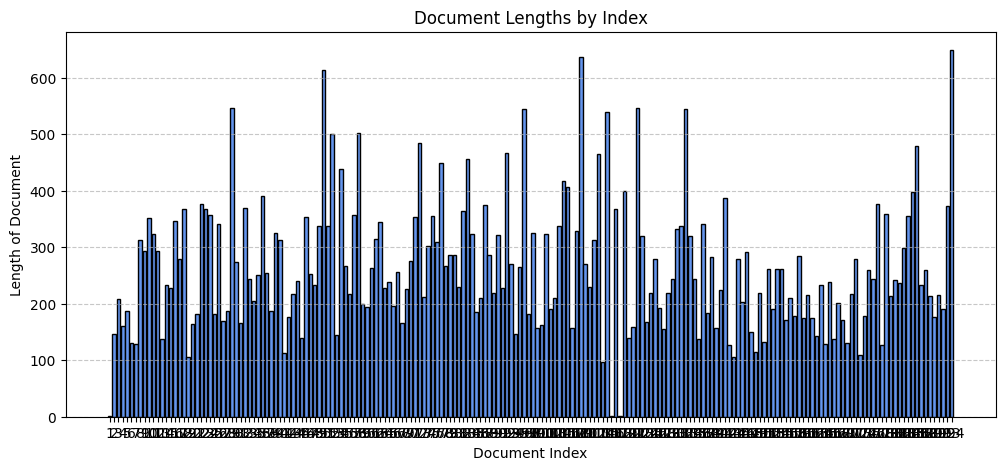

In [7]:
import matplotlib.pyplot as plt

# 각 문서 길이 계산 (문자 수 기준)
doc_lengths = [len(doc.page_content) for doc in langchain_docs]

# 문서 최소, 평균 길이 출력
print('문서의 최대 길이 :', max(doc_lengths))
print('문서의 최소 길이 :', min(doc_lengths))
print('문서의 평균 길이 :', sum(doc_lengths) / len(doc_lengths))

# 문서 인덱스 (1, 2, 3, …)
doc_indices = range(1, len(langchain_docs) + 1)

# 막대그래프 그리기
plt.figure(figsize=(12, 5))
plt.bar(doc_indices, doc_lengths, color='cornflowerblue', edgecolor='black')
plt.xlabel('Document Index')
plt.ylabel('Length of Document')
plt.title('Document Lengths by Index')
plt.xticks(doc_indices)  # 문서 번호 표시
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
doc_lengths_10 = [doc for doc in langchain_docs if len(doc.page_content) < 10]

# 몇 개 있는지 출력
print(f"길이가 10 이하인 문서 개수: {len(doc_lengths_10)}")

길이가 10 이하인 문서 개수: 3


In [9]:
doc_lengths_10

[Document(metadata={'chunk_index': 1, 'category': '집'}, page_content='\ufeff'),
 Document(metadata={'chunk_index': '18-2', 'category': '사람'}, page_content='■'),
 Document(metadata={'chunk_index': '19-2', 'category': '사람'}, page_content='■')]

In [10]:
langchain_docs[0]

Document(metadata={'chunk_index': 1, 'category': '집'}, page_content='\ufeff')

In [11]:
# 기존 langchain_docs에서 길이가 10 이하인 문서 제거
langchain_docs = [doc for doc in langchain_docs if len(doc.page_content.strip()) > 10]

print(f"학습 데이터 문서 개수: {len(langchain_docs)}")

학습 데이터 문서 개수: 191


In [12]:
docs = [doc.page_content for doc in langchain_docs]
docs[0]

'1. 제목: HTP : 집 집은 일상생활에서의 가정생활, 또는 가족 내에서의 자신에 대한 인식을 나타낸다. 자신의 현실의 모습일 수도 있고, 또는 자신이 바라는 모습, 또는 가족의 생활패턴을 나타낸다. 지붕 지붕의 핵심은 머리로 상상할 수 있는 생각을 나타낸다.'

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForCausalLM
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
# 파인튜닝된 임베딩 모델 로드
embedding_model_name = "HJUNN/bge-m3b-Art-Therapy-embedding-fine-tuning"
embed_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embed_model = AutoModel.from_pretrained(embedding_model_name).to(device)

In [14]:
def get_embedding(text):
    """텍스트를 임베딩 벡터로 변환"""
    inputs = embed_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        emb = embed_model(**inputs).last_hidden_state[:,0,:]  # [CLS] 토큰
        emb = emb / emb.norm(dim=1, keepdim=True)  # 정규화
    return emb.cpu().numpy()

In [15]:
# wrapper 만들기
from langchain.embeddings.base import Embeddings

class MyEmbeddings(Embeddings):
    def __init__(self, model, tokenizer, device="cpu"):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def embed_documents(self, texts):
        """리스트[str] -> 리스트[np.ndarray]"""
        return [self.embed_query(t) for t in texts]

    def embed_query(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
        with torch.no_grad():
            emb = self.model(**inputs).last_hidden_state[:, 0, :]
            emb = emb / emb.norm(dim=1, keepdim=True)
        return emb.cpu().numpy()[0]



In [16]:
from langchain_community.vectorstores import Chroma  # ✅ 수정

embeddings = MyEmbeddings(embed_model, embed_tokenizer, device=device)

# Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents=langchain_docs,
    embedding=embeddings,
    collection_name="htp_collection",
    persist_directory="./chroma_store"
)

# 영구 저장
vectorstore.persist()
print("✅ 벡터 DB 생성 완료!")

✅ 벡터 DB 생성 완료!


C:\Users\helen\AppData\Local\Temp\ipykernel_32796\3077111381.py:14: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [17]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('BAAI/bge-reranker-v2-m3')

In [18]:
from typing import Any, List
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun

class Retriever_with_cross_encoder(BaseRetriever):
    vectorstore: Any
    crossencoder: Any
    k: int
    rerank_top_k: int

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        """필수 구현 메서드 (언더스코어로 시작)"""
        # 첫번째 검색 결과 k개 (기본값=5)
        initial_docs = self.vectorstore.similarity_search(query, k=self.k)

        # pairs = 검색 문서와 검색어의 모든 쌍들
        pairs = [[query, doc.page_content] for doc in initial_docs]

        # 검색 문서와 검색어가 모두 입력으로 사용.
        scores = self.crossencoder.predict(pairs)
        scored_docs = sorted(zip(initial_docs, scores), key=lambda x: x[1], reverse=True)

        # 점수가 높은 top k만 남긴다. (기본값=2)
        return [doc for doc, _ in scored_docs[:self.rerank_top_k]]

In [19]:
cross_encoder_retriever = Retriever_with_cross_encoder(
    vectorstore=vectorstore,
    crossencoder=cross_encoder,
    k=20,
    rerank_top_k=10
)

In [20]:
# 멀티 쿼리 재생성 모델 정의
class MultiQueryGenerator(BaseModel):
    queries : List[str] = Field(description= "사용자 질문에서 추출한 검색 쿼리 목록")

In [21]:
from re import template

# Hugging Face 모델 기반 쿼리 재작성기
class AdvancedQueryRewriter:
    def __init__(self, model_name="Qwen/Qwen2.5-7B-Instruct"):
        """
        Hugging Face 모델을 사용한 쿼리 재작성기
        Args:
            model_name: Hugging Face 모델 이름
        """
        print(f"✅ 쿼리 재작성 모델 로딩 중: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        
        # ✅ device_map 없이 로드하고 수동으로 디바이스 할당
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            trust_remote_code=True
        ).to(self.device)
        
        self.model.eval()
        print(f"✅ 쿼리 재작성 모델 로딩 완료! Device: {self.device}")

        # 영어 프롬프트 템플릿
        self.template = """You are an assistant that regenerates search queries based on the user's previous conversations and questions.

# Instructions
1. Reference all previous queries/retrieved documents/answers in the history below to generate more accurate search queries.
2. If the current question is ambiguous or incomplete, use the history to reconstruct a contextually complete query.
3. If there is no history or it's not relevant, use only the current question.
4. Always generate clear and search-appropriate queries.
5. The output should contain only the regenerated query strings. Do not include additional explanations or comments.
6. If the current sentence contains multiple attributes, separate each into individual queries.
7. Each query should be complete and clear enough to be independently searchable in a vector DB.
8. When combined, the separated queries should represent the meaning of the original query.

# Input
Full conversation history: {history_text}
Current question: {current_query}

# Output Format
You must output in the following JSON format:
{{
    "queries": ["query1", "query2", ...]
}}

Example:
If the current question is "What about Seoul? And restaurants?" and the previous conversation was "Recommend tourist spots in Korea",
{{
    "queries": ["Recommend tourist spots in Seoul", "Recommend restaurants in Seoul"]
}}

Single query case:
{{
    "queries": ["Recommend tourist spots in Korea"]
}}
"""

    def rewrite_query(self, history_text: str, current_query: str) -> List[str]:
        if not history_text.strip():
            history_text = "No previous conversation"

        try:
            # 프롬프트 구성
            prompt = self.template.format(
                history_text=history_text,
                current_query=current_query
            )
            
            # Qwen 형식으로 포맷팅
            messages = [
                {"role": "system", "content": "You are a helpful assistant for query rewriting."},
                {"role": "user", "content": prompt}
            ]
            
            formatted_prompt = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            
            # 토큰화 및 생성
            inputs = self.tokenizer(formatted_prompt, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=500,
                    temperature=0.1,
                    do_sample=True,
                    top_p=0.9,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )
            
            # 디코딩
            response = self.tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
            
            # JSON 파싱
            try:
                import json
                import re
                
                # JSON 부분만 추출
                json_match = re.search(r'\{[^{}]*"queries"[^{}]*\}', response, re.DOTALL)
                if json_match:
                    response_json = json.loads(json_match.group())
                else:
                    response_json = json.loads(response)
                
                if "queries" in response_json and isinstance(response_json["queries"], list):
                    return response_json["queries"]
                else:
                    print(f"Response doesn't contain 'queries' list: {response}")
                    return [current_query]
            except (json.JSONDecodeError, Exception) as e:
                print(f"JSON parsing error: {str(e)}")
                print(f"Model raw response: {response}")
                return [current_query]
                
        except Exception as e:
            print(f"Error during query rewriting: {str(e)}")
            return [current_query]


In [22]:
# 멀티 쿼리 검색 클래스 정의
class MultiQueryRetriever:
    def __init__(self, vectorstore, query_rewriter, **kwargs):
        self.vectorstore = vectorstore
        self.query_rewriter = query_rewriter
        self.history = []

    def build_history_text(self) -> str:
        text = ""
        for h in self.history:
            text += f"[QUESTION]\n{h['user_query']}\n"
            text += f"[REWRITTEN QUERIES]\n{h['rewritten_queries']}\n"
            text += "[RETRIEVED DOCS]\n"
            for d in h["retrieved_docs"]:
                text += f"- {d['content']}\n"
            text += f"[ANSWER]\n{h['final_answer']}\n"
            text += "-"*40 + "\n"
        return text

    def retrieve(self, query:str, num_docs = 3)-> List[Document]:

        history_text = self.build_history_text()

        rewritten_queries = self.query_rewriter.rewrite_query(
            history_text=history_text,
            current_query=query
        )

        print(f"원래 쿼리: {query}")
        print(f"재생성된 쿼리들: {rewritten_queries}")

        # 모든 쿼리에 대해 검색 수행 및 결과 병합
        all_docs = []
        seen_contents = set()

        # 다수의 쿼리가 주어졌을 때 1개씩 검색해본다.
        for idx, rewritten_query in enumerate(rewritten_queries):
            print(f"쿼리 {idx+1} : {rewritten_query}")

            #  벡터 검색 수행
            docs = self.vectorstore.similarity_search(rewritten_query, k = num_docs)

            # 중복 제거하여 문서 추가
            for doc in docs:
                if doc.page_content not in seen_contents:
                    seen_contents.add(doc.page_content)

                    #메타데이터에 쿼리 정보 추가
                    if not hasattr(doc, "metadata") or doc.metadata is None:
                        doc.metadata = {}
                    doc.metadata['query'] = rewritten_query
                    all_docs.append(doc)

        print(f"총 {len(all_docs)}개의 고유 문서를 검색했습니다.")
        return all_docs, rewritten_queries


In [ ]:
# RAG 응답 생성 클래스 정의 (Hugging Face 업로드된 모델 사용)
class AdvancedConversationalRAG:
    def __init__(self, vectorstore, model_name="helena29/Qwen2.5_LoRA_for_HTP"):
        """
        Hugging Face에 업로드된 fine-tuned 모델을 사용한 대화형 RAG 시스템
        Args:
            vectorstore: 벡터 저장소
            model_name: Hugging Face 모델 이름 (기본값: helena29/Qwen2.5_LoRA_for_HTP)
        """
        # history에 대화 저장
        self.history = []
        
        # 쿼리 재생성기 (동일한 모델 사용)
        self.query_rewriter = AdvancedQueryRewriter(model_name=model_name)
        
        # 각각의 검색어를 따로 검색한 뒤에 검색결과를 취합하는 멀티쿼리 리트리버
        self.retriever = MultiQueryRetriever(vectorstore=vectorstore, query_rewriter=self.query_rewriter)
        
        # 답변 생성용 모델 로드 (쿼리 재작성기와 같은 모델 재사용)
        print(f"✅ 답변 생성에도 동일 모델 사용: {model_name}")
        self.tokenizer = self.query_rewriter.tokenizer
        self.llm = self.query_rewriter.model
        self.device = self.query_rewriter.device
        print(f"✅ 모델 설정 완료! Device: {self.device}")

        # 응답 생성을 위한 프롬프트 템플릿 (영어 버전)
        self.response_template = """You are a professional psychologist specialized in HTP (House-Tree-Person) test interpretation.
Your role is to provide clear, professional psychological interpretations based on drawing features.

User Question: {query}

Please provide your interpretation based on the following reference information:
{context}

Guidelines:
1. If the user's question contains multiple queries, address each one clearly and separately.
2. Base your answer only on the provided information. If information is insufficient, honestly state that you don't know.
3. Provide your answer in Korean language.
4. If there are original sources in the provided information, cite them appropriately.
5. Explain possible psychological meanings in a professional manner.

Answer:"""
        
    def generate_response(self, prompt: str) -> str:
        """Fine-tuned 모델로 응답 생성"""
        # Qwen 형식으로 포맷팅
        messages = [
            {"role": "system", "content": "You are a professional psychologist specialized in HTP test interpretation."},
            {"role": "user", "content": prompt}
        ]
        
        formatted_prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # 토큰화 및 생성 (디바이스 명시적 지정)
        inputs = self.tokenizer(formatted_prompt, return_tensors="pt")
        
        # ✅ 모든 입력 텐서를 모델과 같은 디바이스로 이동
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.llm.generate(
                **inputs,
                max_new_tokens=1024,
                temperature=0.3,
                do_sample=True,
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )
        
        # 디코딩 (입력 부분 제외)
        response = self.tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
        return response.strip()
        
    def query(self, current_query: str) -> Dict:
        # 관련 문서검색
        docs, rewritten_queries = self.retriever.retrieve(current_query)

        # 문서 내용을 컨텍스트로 변환
        if docs:
            context = "\n\n".join([f"문서 {i+1}:\n{doc.page_content}" for i, doc in enumerate(docs)])
            formatted_prompt = self.response_template.format(query=current_query, context=context)
        else:
            # 문서 없으면 일반 지식 기반 답변 생성
            formatted_prompt = f"User Question: {current_query}\n\nNo documents were retrieved, but please provide an appropriate answer based on your knowledge."

        # Fine-tuned LLM으로 응답 생성
        response = self.generate_response(formatted_prompt)

        # 히스토리에 저장
        record = {
            "user_query": current_query,
            "rewritten_queries": rewritten_queries,
            "retrieved_docs": [
                {"content": d.page_content, "metadata": d.metadata} for d in docs
            ],
            "final_answer": response
        }
        self.history.append(record)
        self.retriever.history.append(record)

        # 결과 반환
        return {
            "query": current_query,
            "result": response,
            "rewritten_queries": rewritten_queries,
            "source_documents": docs
        }


In [24]:
conversational_rag = AdvancedConversationalRAG(vectorstore)

✅ 쿼리 재작성 모델 로딩 중: helena29/Qwen2.5_LoRA_for_HTP


`torch_dtype` is deprecated! Use `dtype` instead!
Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\helen\anaconda3\envs\LLMenv\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\helen\anaconda3\envs\LLMenv\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\helen\anaconda3\envs\LLMenv\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\helen\anaconda3\envs\LLMenv\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\helen\anaconda3\envs\LLMenv\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 6: invalid start byte


✅ 쿼리 재작성 모델 로딩 완료! Device: cuda
✅ 답변 생성에도 동일 모델 사용: helena29/Qwen2.5_LoRA_for_HTP
✅ 모델 설정 완료! Device: cuda


In [25]:
# 예시 1: 첫 번째 질문 (이전 대화 없음)
query1 = "손이 크고, 눈썹이 진한 사람 그림"
print("\n" + "="*50)
print(f"질문 1: {query1}")
result1 = conversational_rag.query(query1)
print(f"답변 1:\n{result1['result']}")


질문 1: 손이 크고, 눈썹이 진한 사람 그림
원래 쿼리: 손이 크고, 눈썹이 진한 사람 그림
재생성된 쿼리들: ['generate portrait with large hands and dark eyebrows']
쿼리 1 : generate portrait with large hands and dark eyebrows
총 1개의 고유 문서를 검색했습니다.
답변 1:
The presence of an oversized hand, combined with a dark eyebrow line, suggests a potential for impulsivity and a tendency towards overreactions. This could be indicative of anxiety or a need for control, as individuals often associate large hands with feelings of being overwhelmed or threatened. The dark eyebrows might reflect a guarded personality or difficulty expressing emotions openly. Further exploration would involve assessing the overall drawing style and any additional details provided by the subject.


In [26]:
# 예시 2: 두 번째 질문
query2 = "손가락을 자세히 나타냈어"
print("\n" + "="*50)
print(f"질문 2: {query2}")
result2 = conversational_rag.query(query2)
print(f"답변 2:\n{result2['result']}")


질문 2: 손가락을 자세히 나타냈어
원래 쿼리: 손가락을 자세히 나타냈어
재생성된 쿼리들: ['generate portrait with large hands and dark eyebrows', 'retrieve documents related to large hands and dark eyebrows']
쿼리 1 : generate portrait with large hands and dark eyebrows
쿼리 2 : retrieve documents related to large hands and dark eyebrows
총 1개의 고유 문서를 검색했습니다.
답변 2:
Based on the detailed hand drawing of the 'Person' section, particularly the large hands, this indicates an intense need for control, impulsivity, or a feeling of being overwhelmed by their actions. The individual may be experiencing significant anxiety or difficulty regulating their behavior due to a perceived lack of self-control. This could point towards conditions like obsessive-compulsive disorder or a personality type prone to impulsive decision-making.


In [27]:
# 예시 3: 세 번째 질문
query3 = "창문이 크게 있어"
print("\n" + "="*50)
print(f"질문 3: {query3}")
result3 = conversational_rag.query(query3)
print(f"\n답변 3:\n{result3['result']}")

# 인용한 문서 확인
print("\n" + "="*50)
print("\n참조 문서들:")
for i, doc in enumerate(result3['source_documents'], 3):
    print(f"\n문서 {i}:")
    print(doc.page_content)
    print("메타데이터:", doc.metadata)


질문 3: 창문이 크게 있어
원래 쿼리: 창문이 크게 있어
재생성된 쿼리들: ['generate portrait with large windows', 'retrieve documents related to expansive windows']
쿼리 1 : generate portrait with large windows
쿼리 2 : retrieve documents related to expansive windows
총 2개의 고유 문서를 검색했습니다.

답변 3:
The large window depicted in the HTP suggests an overemphasis on interpersonal relationships and potential anxieties related to social connections. This could indicate difficulties with assertiveness or a fear of rejection, as evidenced by the repeated mention of 'he' and 'she' within the document. The individual may be struggling with self-esteem issues and a tendency to project their concerns onto others rather than addressing their own vulnerabilities. This aligns with the documented history of anxiety and a need for control, suggesting a potential underlying personality disorder characterized by excessive worry and a fear of negative outcomes.


참조 문서들:

문서 3:
■ 창문을 강조하며 그린다 인간관계에 대한 과한 걱정이 존재한다
메타데이터: {'chunk_index': '6-8'

In [28]:
conversational_rag.history

[{'user_query': '손이 크고, 눈썹이 진한 사람 그림',
  'rewritten_queries': ['generate portrait with large hands and dark eyebrows'],
  'retrieved_docs': [{'content': '■ 극단적으로 큰 손을 그린다 자신의 무언가가 옳지 않다, 또는 자신이 모자라다는 느낌을 갖는다 충동적으로 행동한다',
    'metadata': {'chunk_index': '26-17',
     'category': '사람',
     'query': 'generate portrait with large hands and dark eyebrows'}}],
  'final_answer': 'The presence of an oversized hand, combined with a dark eyebrow line, suggests a potential for impulsivity and a tendency towards overreactions. This could be indicative of anxiety or a need for control, as individuals often associate large hands with feelings of being overwhelmed or threatened. The dark eyebrows might reflect a guarded personality or difficulty expressing emotions openly. Further exploration would involve assessing the overall drawing style and any additional details provided by the subject.'},
 {'user_query': '손가락을 자세히 나타냈어',
  'rewritten_queries': ['generate portrait with large hands and dark eye

In [29]:
# 대화 히스토리를 JSON 파일로 저장
import json
from datetime import datetime

# 현재 시간을 파일명에 포함
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"conversational_rag_history_{timestamp}.json"

# history를 JSON으로 저장
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(conversational_rag.history, f, ensure_ascii=False, indent=2)

print(f"✅ 대화 히스토리가 '{filename}'에 저장되었습니다!")
print(f"총 {len(conversational_rag.history)}개의 대화가 저장되었습니다.")


✅ 대화 히스토리가 'conversational_rag_history_20251121_124401.json'에 저장되었습니다!
총 3개의 대화가 저장되었습니다.
